In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np 

def make_scaler2(x_tmp ):
    #this will get a min and max for each channel
    
    linx= []
    
    x_tmp=x_tmp.reshape(x_tmp.shape[0],x_tmp.shape[1],x_tmp.shape[3]**2)#color in 2nd channel

    for color in range(x_tmp.shape[1]):
        linx.append(np.zeros(x_tmp.shape[0]*x_tmp.shape[2]) ) #x.shape[2] =101*101
        for image in range(x_tmp.shape[0]):
            linx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]] = x_tmp[image][color]

    
    minmax_dict = {"max": [],"min": [] } 
    for color in range(x_tmp.shape[1]):
        minmax_dict['max'].append(linx[color].reshape(-1).max())
        minmax_dict['min'].append(linx[color].reshape(-1).min())
        

            
    #print(linx[0]==linx[1])#linx[1].reshape(-1, 1).shape)
    return minmax_dict

def scale_data2(x_tmp, minmax_dict):
    linx= []
    
    #reshape
    x_tmp=x_tmp.reshape(x_tmp.shape[0],x_tmp.shape[1],x_tmp.shape[3]**2)
    
    #get it in a line
    for color in range(x_tmp.shape[1]):
        linx.append(np.zeros(x_tmp.shape[0]*x_tmp.shape[2]) ) #x.shape[2] =101*101
        for image in range(x_tmp.shape[0]):
            linx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]] = x_tmp[image][color]
        print(linx[color].max())
    #transform/scale
    transx = []
    for color in range(x_tmp.shape[1]): 
        X_std = (linx[color] - minmax_dict["min"][color]) / (minmax_dict["max"][color] - minmax_dict["min"][color])
        #X_scaled = X_std * (minmax_dict["max"][color] - minmax_dict["min"][color]) + minmax_dict["min"][color]
        transx.append(X_std)
 
    #store in original 4d array
    for image in range(x_tmp.shape[0]):
        for color in range(x_tmp.shape[1]):
            x_tmp[image][color] = transx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]].reshape(1,-1) 
    #reshape back to original dimensions
    x_tmp = x_tmp.reshape(x_tmp.shape[0],1,100,100)
    return x_tmp

In [1]:
# MERGE AND SAVE

from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

LENSES_PATH = "lenses/lens_image_"
OUT_PATH = "/run/media/toyonagar/Lexar/out/out"
#MERGED_PATH = "/run/media/toyonagar/Lexar/merged/merged_"
MERGED_PATH = "/run/media/toyonagar/Lexar/merged_based_on_real/merged0-1_"
hm_lenses = int(input("How many lenses do you want to merge with associated cutouts? "))

alpha = [0.20, 0.14, 0.08, 0.02]
#alpha = [1]

def normalize( all_cutouts, all_lenses, hm_lenses): #only for 1 color channel. Scale both (0,1)
    bad_images = []
    for lens_number in range(hm_lenses):
        try:
            #scale the lenses
            for i in range(len(alpha)): #array axis 0 = [..all one weight.., all another weight..]
                tmp_lens = all_lenses[lens_number + hm_lenses*i][0].reshape(-1,)
            
                tmp_lens = minmax_scale(tmp_lens, feature_range = (0, 1*alpha[i]))
                all_lenses[lens_number + hm_lenses*i][0] = tmp_lens.reshape(all_lenses.shape[2],all_lenses.shape[2])
            
                #scale the cutouts
                tmp_lens2 = all_cutouts[lens_number + hm_lenses*i][0].reshape(-1,)
             
                tmp_lens2 = minmax_scale(tmp_lens2, feature_range = (0,1))
                all_cutouts[lens_number + hm_lenses*i][0] = tmp_lens2.reshape(all_cutouts.shape[2],all_cutouts.shape[2])

        except:
            bad_images.append(lens_number)
            print ("image contains NaN")
    
    hm_lenses -=len(bad_images)        
    all_lenses = np.delete(all_lenses,bad_images, axis=0)
    all_cutouts = np.delete(all_cutouts,bad_images, axis=0)

    
 
    return all_cutouts, all_lenses
    

def load_images(sample_num): #NEED TO LOAD THE SAME IMAGE FOUR TIMES INTO all_cutouts
    pass
   
    lens = fits.open(LENSES_PATH+str(sample_num)+".fits")[0].data #PATH will  run dir
    

    cutout = fits.open(OUT_PATH+str(sample_num)+".fits")[0].data 

    cutout = cutout.reshape(1,cutout.shape[0],cutout.shape[1])
    lens = lens.reshape(1,lens.shape[0],lens.shape[1])
  
    return cutout, lens
    

def save_images(hm_lenses, merged): #unused
    
    for image in range(len(merged)):
        fits.writeto(MERGED_PATH + str(image)+'.fits', merged[image], overwrite =True) 
        
def save_image(image_number, merged):
    fits.writeto(MERGED_PATH + str(image_number)+'.fits', merged, overwrite =True) 

def sum_images(all_cutouts, all_lenses, hm_lenses): #only sums in 2D, no color channel,need to save periodically
    summed_list = []
    for image_number in range(hm_lenses*len(alpha)):    
        try:
            #sum
            summed=np.add(all_cutouts[image_number][0], all_lenses[image_number][0])
            #renormalize
            print image_number
            tmp_image = summed.reshape(-1,)
            tmp_image = minmax_scale(tmp_image, feature_range = (0,1))
            summed = tmp_image.reshape(summed.shape[0],summed.shape[1])
            #save
            if summed.mean()==0:
                hm_lenses -=1
                print( "image is blank")
                continue
            save_image(image_number, summed)
            summed_list.append(summed)
        except:
            hm_lenses -=1
            
            print("failed at adding images together, re-normalizing, and saving "+str(image_number))
            
    return summed_list




all_cutouts = np.zeros((hm_lenses*len(alpha),1,100,100))
all_lenses = np.zeros((hm_lenses*len(alpha),1,100,100))

bad_images = [] #keep track of and remove bad images later

for image in range(hm_lenses):
    
    try:
        #load each image into 4 spots in each respective array
        for weight in range(len(alpha)):
            all_cutouts[image + hm_lenses*weight], all_lenses[image+hm_lenses*weight] = load_images(image)
            #all_cutouts[image], all_lenses[image] = load_lenses(image)

    except:
        bad_images.append(image)
        print("couldnt find image: " +str(image))
        
hm_lenses -=len(bad_images)        
all_cutouts = np.delete(all_cutouts,bad_images, axis=0)
all_lenses = np.delete(all_lenses,bad_images, axis=0)
    
print("images loaded") 

all_cutouts, all_lenses = normalize(all_cutouts, all_lenses, hm_lenses)

print("images normalized")   
    
merged = sum_images(all_cutouts, all_lenses, hm_lenses)  

print("images merged, re-normalized, and saved") 


        
#save_images(hm_lenses, merged)
#print(" merged images saved ")

How many lenses do you want to merge with associated cutouts? 500
couldnt find image: 2
couldnt find image: 14
couldnt find image: 15
couldnt find image: 18
couldnt find image: 19
couldnt find image: 20
couldnt find image: 22
couldnt find image: 23
couldnt find image: 25
couldnt find image: 29
couldnt find image: 30
couldnt find image: 31
couldnt find image: 35
couldnt find image: 37
couldnt find image: 38
couldnt find image: 39
couldnt find image: 42
couldnt find image: 46
couldnt find image: 49
couldnt find image: 51
couldnt find image: 56
couldnt find image: 61
couldnt find image: 63
couldnt find image: 65
couldnt find image: 66
couldnt find image: 67
couldnt find image: 69
couldnt find image: 71
couldnt find image: 75
couldnt find image: 77
couldnt find image: 83
couldnt find image: 84
couldnt find image: 88
couldnt find image: 91
couldnt find image: 94
couldnt find image: 99
couldnt find image: 103
couldnt find image: 109
couldnt find image: 112
couldnt find image: 113
couldnt fin

576
577
failed at adding images together, re-normalizing, and saving 577
578
image is blank
579
580
581
582
image is blank
583
584
585
586
image is blank
587
failed at adding images together, re-normalizing, and saving 587
588
589
590
591
failed at adding images together, re-normalizing, and saving 591
592
593
594
595
image is blank
596
597
598
image is blank
599
600
601
failed at adding images together, re-normalizing, and saving 601
602
603
image is blank
604
605
606
607
608
failed at adding images together, re-normalizing, and saving 608
609
610
611
612
613
image is blank
614
615
616
617
618
619
620
621
622
623
failed at adding images together, re-normalizing, and saving 623
624
image is blank
625
image is blank
626
image is blank
627
image is blank
628
image is blank
629
630
631
image is blank
632
633
634
failed at adding images together, re-normalizing, and saving 634
635
636
image is blank
637
638
639
failed at adding images together, re-normalizing, and saving 639
640
641
642
im

1322
1323
1324
1325
image is blank
1326
image is blank
1327
1328
1329
image is blank
1330
image is blank
1331
image is blank
1332
failed at adding images together, re-normalizing, and saving 1332
1333
image is blank
1334
image is blank
1335
1336
image is blank
1337
failed at adding images together, re-normalizing, and saving 1337
1338
1339
1340
image is blank
1341
image is blank
1342
image is blank
1343
1344
1345
1346
image is blank
1347
1348
image is blank
1349
image is blank
1350
image is blank
1351
1352
1353
image is blank
1354
1355
1356
1357
image is blank
1358
1359
1360
image is blank
1361
1362
image is blank
1363
1364
1365
1366
1367
image is blank
1368
1369
1370
1371
1372
image is blank
1373
1374
image is blank
1375
1376
image is blank
1377
image is blank
1378
image is blank
1379
1380
image is blank
1381
1382
image is blank
1383
1384
1385
1386
image is blank
1387
1388
image is blank
1389
1390
1391
1392
1393
1394
image is blank
1395
image is blank
1396
1397
1398
1399
image is blan

In [132]:
hm_lenses

392

In [4]:

import numpy as np
merged = np.array(merged)

np.save("merged_dimmed",merged)


(1213, 100, 100)

In [14]:
tmp = np.load("sim_lenses.npy(20,1,100,100).npy")

('no-neg mean: 0.130760966748', 'negative samples mean: 0.353801588917', 'norm 0-1 mean0.244087644905')


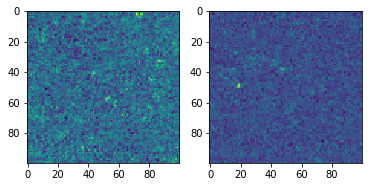

In [126]:
#For testing diff between negatives and merged images
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

im=883
m = fits.open("/run/media/toyonagar/Lexar/merged/merged_"+str(im)+".fits")[0].data
#m1 = fit7.open("/run/media/toyonagar/Lexar/merged1/merged_"+str(im)+".fits")[0].data
o = fits.open("/run/media/toyonagar/Lexar/negatives/out"+str(im)+".fits")[0].data
m01 = fits.open(MERGED_PATH+str(im)+".fits")[0].data

print ("no-neg mean: "+str(m.mean()), "negative samples mean: "+str(o.mean()),"norm 0-1 mean" +str(m01.mean())) 
plt.subplot(121)
plt.imshow(o) 
plt.subplot(122)
plt.imshow(m01)



(array([  9.98000000e+03,   1.00000000e+01,   3.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

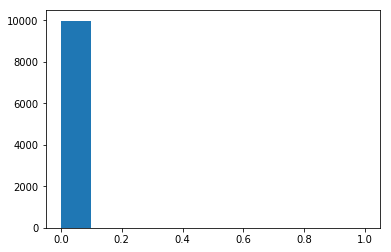

In [196]:
plt.hist(o.reshape(-1))

In [13]:
#import all the data. This will load the data into "ims" (set_size, color, 100,100) and "y" (set_size , 1) 
import numpy as np
import os 
from astropy.io import fits

NEG_PATH = "/run/media/toyonagar/Lexar/negatives/"
POS_PATH = "/run/media/toyonagar/Lexar/merged/"
OLD_POS_PATH = "/run/media/toyonagar/Lexar/merged1/"

set_size=500
pos = np.ones((set_size, 1, 100, 100))
oldpos = np.ones((set_size, 1, 100, 100))
neg = np.ones((set_size, 1, 100, 100))
#load the negatives into even numbered indices (including 0)
count =0
for filename in os.listdir(POS_PATH):
    if filename.endswith(".fits") and count<set_size: 
        pos[count] = fits.open(POS_PATH+filename)[0].data
        
        
        count+=1
count =0
for filename in os.listdir(OLD_POS_PATH):
    if filename.endswith(".fits") and count<set_size: 
      
        oldpos[count] = fits.open(OLD_POS_PATH+filename)[0].data

        count+=1    
    
count =0
for filename in os.listdir(NEG_PATH):
    if filename.endswith(".fits") and count<set_size: 
     
        neg[count] = fits.open(NEG_PATH+filename)[0].data
        
        count+=1
print("the averages of 500 samples from each respective group: ")
print ("positive samples without neg pixels: "+str(pos.mean()))
print( "negative samples: "+ str(neg.mean()))
print( " positive samples with neg pix: "+str(oldpos.mean()))         


the averages of 500 samples from each respective group: 
positive samples without neg pixels: 0.185752629454
negative samples: 0.233798937586
 positive samples with neg pix: 0.347581070713
